# Chapter 11: Flood Frequency and Functions

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2025-12-11

# Flood Frequency Analysis and Creating Functions

## Template Repository

The following activity is available as a template github repository at
the following link:

## Intro

This methods for this chapter are adapted from the following activity:
https://serc.carleton.edu/hydromodules/steps/166250.html

After working with Flow Duration Curves (FDCs) and performing a low flow
analysis, we now understand all the concepts necessary to perform a
flood frequency analysis. In this chapter we will perform a flood
frequency analysis using a Gumbel extreme value distribution and then
write our own function that will return the magnitude of whatever
probability flood we want!

First we will load the tidyverse and dataRetrieval packages and the set
the theme for our plots.

In [ ]:
library(tidyverse)
library(dataRetrieval)
library(extRemes)
library(modelr)

theme_set(theme_classic())

Next, download the yearly peakflow data from USGS dataRetrieval using
the readNWISpeak() function. We don’t have to create our own yearly
values like we did in the low flow analysis. This function just returns
the highest flow for each year.

Download the data for the New River at Radford.

Then make a plot of the peak flow for each year.

ALERT: All NWIS services are slated for decommission
and new dataRetrieval functions will be added.
For up-to-date information, see: 
https://doi-usgs.github.io/dataRetrieval/articles/Status.html

GET: https://nwis.waterdata.usgs.gov/usa/nwis/peak/?range_selection=date_range&format=rdb&site_no=03171000

GET: https://waterservices.usgs.gov/nwis/site/?siteOutput=Expanded&format=rdb&site=03171000

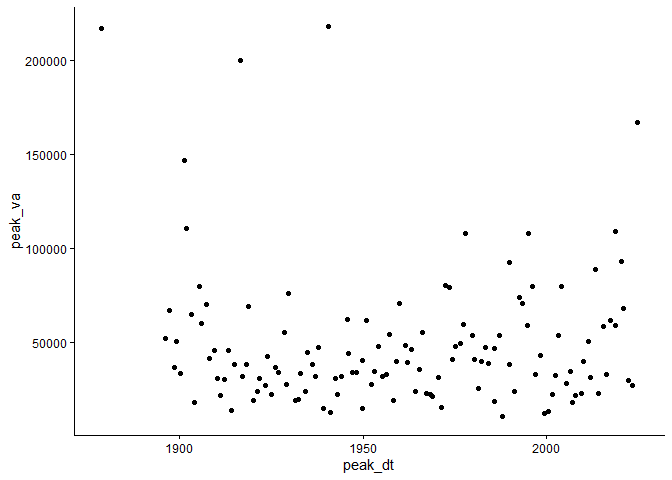

In [ ]:
radford <- "03171000"

peakflows <- readNWISpeak(radford)

As with the couple previous chapters, the next step is to create a
column that contains the ranks of each flow in the record. Create a
column that has the rank of each flow, with the highest flow ranked #1.
Use select() to trim your dataset to just the peak data, peak values,
and ranks columns.

Make the plot from the last code chunk again but color the points by
rank to check that this worked. Also, look at the data through the
environment tab in rstudio or using head() to double check.

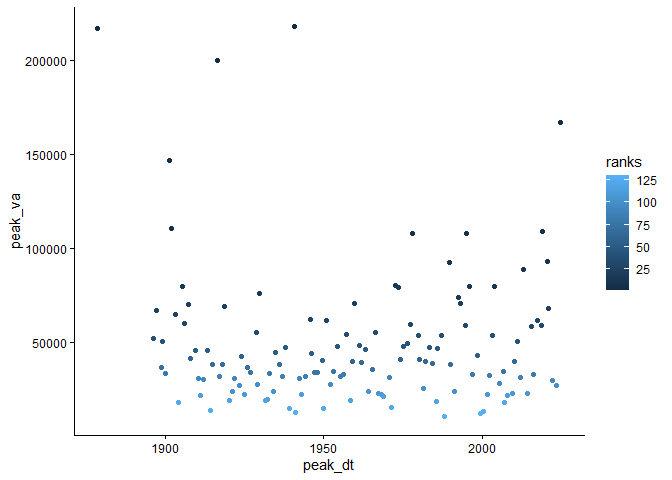

     peak_dt peak_va ranks
1 1878-09-15  217000   2.0
2 1896-04-01   52400  41.0
3 1897-02-22   67200  25.0
4 1898-09-23   37200  71.0
5 1899-03-05   50600  42.5
6 1900-03-01   34000  79.5

In [ ]:
#create rank column (minus flips the ranking)
#then clean it up, pull out only peak value, date, rank
peakflows <- peakflows |> 
  mutate(ranks = rank(-peak_va)) |>
  select(peak_dt, peak_va, ranks)

#look at it
ggplot(peakflows, 
       aes(peak_dt, peak_va, color = ranks))+
  geom_point()

Now we need to calculate the exceedance probability and return period
for each value in our data. For flood frequency analysis, it is common
to use the Weibull plotting formula:

$Tp = (N + 1) / m$

$Tp$ = Return Period

$N$ = Number of observations in your record

$m$ = Rank of specific observation, m = 1 is the largest, m = N is the
smallest.

------------------------------------------------------------------------

And the return period is the inverse of the exceedance probability so:

Exceedance probability = $p = 1 / Tp$

Non-exceedance probability = $pne = 1 - p$

------------------------------------------------------------------------

In the chunk below, create a column in your dataset and calculate each:
exceedance probability, non-exceedance probability, and return period.

Then make a plot with peak flow on the Y axis and Return Period on the
X.

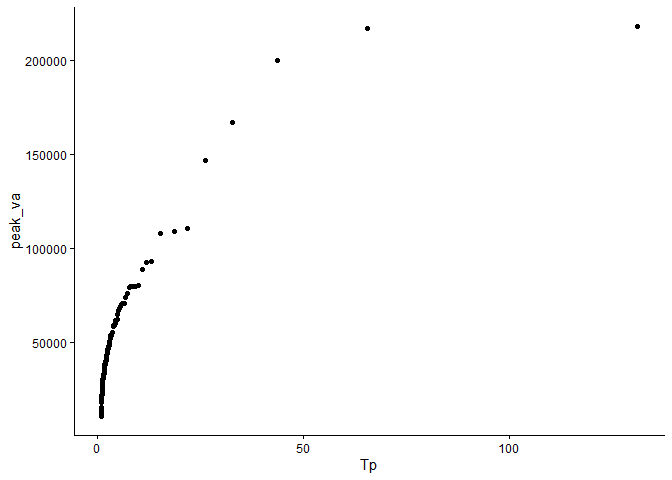

In [ ]:
N <- length(peakflows$peak_dt)

#calculate return period, exceedence/non-exceedence with Weibull
peakflows <- peakflows |>
  mutate(Tp = (N + 1)/ranks,
         pe = 1 / Tp,
         pne = 1 - pe)

#Plot peak flows on y and est return period on the x
peakflows |> 
  ggplot(aes(x = Tp, y = peak_va)) +
  geom_point()

Now we need to fit these data to a distribution in order to make a
relationship we can use to predict the discharge of specific return
intervals.

There are many distributions that can be used in this situation, but a
common one for flood frequency analyses is the Gumbel extreme value
distribution:

![](attachment:images/gumbel.png "Gumbel Distribution")

x is observed discharge data, u and x are parameters that shape the
distribution.

We can calculate u and x in order to create a distribution that best
fits our data with the following equations. Notice **x bar** is mean and
**sx2** is variance. We will need to find **sx**, which is the square
root of the variance, also known as the standard deviation.

![](attachment:images/gumbelparams.png "Gumbel parameters")

In the chunk below, calculate u and alpha by first calculating xbar
(mean) and sx (standard deviation) and then using them in the above
equations for u and x.
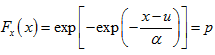
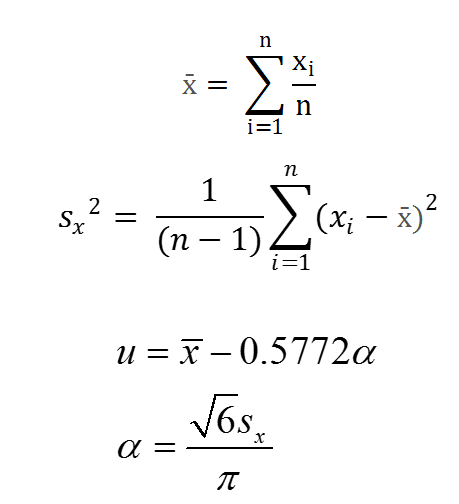

In [ ]:
xbar <- mean(peakflows$peak_va)

sx <- sd(peakflows$peak_va)

alpha <- (sqrt(6)*sx) / pi

u <- xbar - (0.5772 * alpha)

Now that we have the parameters that best represent our data as a Gumbel
Distribution, we can use the formula to create the theoretical values
for the return interval according to that distribution.

![](attachment:images/gumbel.png "Gumbel Distribution")

In the chunk below:

First calculate non-exceedance probability with the equation above.

Then calculate Tp theoretical (the return period) as T was calculated
above Tp = 1 / (1-p)

Finally create a plot of return period on the x axis and peak values on
the y. Include return periods calculated from your data and those
calculated from the Gumbel distribution on your plot as points of
different colors.
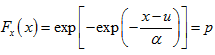

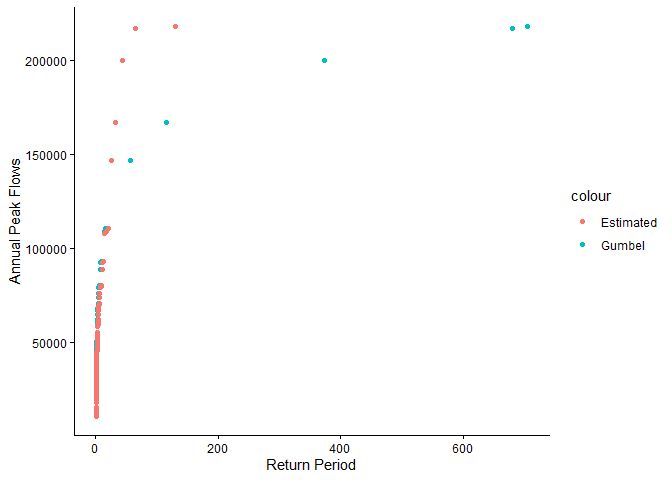

In [ ]:
peakflows <- peakflows |> 
  mutate(
    pne_gumbel = exp(-exp(-((peak_va - u) / alpha)))) |>
  mutate(Tp_gumbel = (1 / (1-pne_gumbel)))


peakflows |> ggplot() +
  geom_point(aes(x = Tp_gumbel, y = peak_va, color = "Gumbel"))+
  geom_point(aes(x = Tp, y = peak_va, color = "Estimated"))+
  ylab("Annual Peak Flows")+
  xlab("Return Period")+
  theme_classic() 

Let’s look at these data a slightly different way to make it easier to
see what is going on and how we can pull of flows for different return
periods.

Make the same plot as above but show the Gumbel distribution values as a
line, with the estimated values as points, and log the x axis with
limits set to 1 - 100. Save this plot, we will add to it later.

With this plot you could look up the return period for any flood or the
discharge level for any return period.

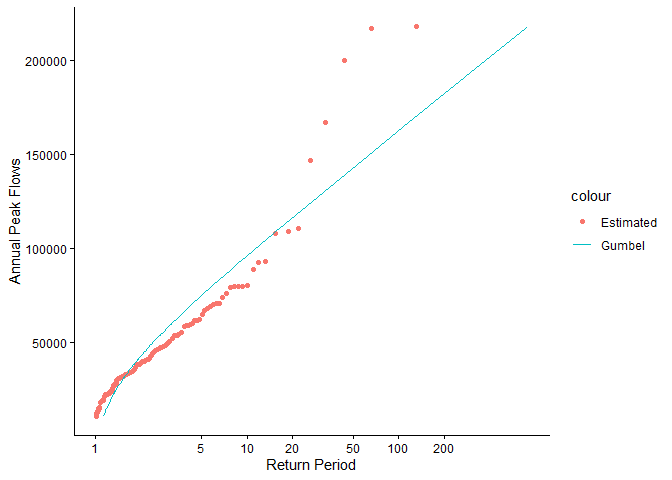

In [ ]:
peakplot <- peakflows |> 
  ggplot() +
  geom_point(aes(x = Tp, y = peak_va, color = "Estimated"))+
  geom_line(aes(x = Tp_gumbel, y = peak_va, color = "Gumbel"))+
  ylab("Annual Peak Flows")+
  xlab("Return Period")+
  scale_x_log10(breaks = c(1,5,10,20,50,100,200))+
  theme_classic()

peakplot

This plot is showing a representation of the fitted distribution by
calculating the return period for each point in our dataset. But we can
also use it to calculated the specific flow that corresponds to any
return period by using the established relationship.

In the chunk below, calculate the magnitude of a 1 in 100 chance, or 100
year flood using the following two formulas where p = non-exceedance
probability and Tp = return period. These are just the equations used to
calculate return period rearranged to calculate peak flow.

p = 1 - (1 / Tp)

peakflow = u - (alpha \* ln(-ln(p)))

(log() in r is the natural log, log10() is base 10 log)

According to this flow, what is the 1 in 100 chance flood at this
location? Do you see any issues with reporting this as the 1 in 100
chance flood? What are they?

In [ ]:
Tp = 100

pne = 1 - (1/Tp)

peak_va = u - (alpha * log(-log(pne)))

The gumbel distribution fit for the New River at Radford isn’t great.
Fortunately there are ways to find an appropriate fit.

The generalized extreme value distribution will fit a much wider range
of extreme value distributions. The distribution has three parameters:

location, scale, and shape

When the shape parameter is 0, the GEV is the same as the Gumbel
Distribution. If it is greater than 0, the GEV is the the same as the
Type II extreme value distribution. If it is less than 0, the GEV is the
the same as the Type III extreme value distribution

Fitting data to this distribution is much more complex than what we did
above with the Gumbel, but there are stats packages available that will
do it for us.

Here we will use the fevd() function from the extRemes package to fit a
generalized extreme value distribution to our data.

Below, do the following - Pass the peak flow values to fevd() and save
the result as “GEVD”. This will save all the outputs from fevd() so we
can use them in a few different ways.

-   Pass the “GEVD” object to summary() and then plot(). You can see the
    GEVD object includes the three parameters: location, scale, and
    shape. plot() also shows you how well the fit turned out using
    several plots.

-   Save the location, scale, and shape parameters. You get them out of
    the GEVD object using the following syntax: GEVD\$results\$par\[#\]
    where \# is 1: Location, 2: Scale, 3: Shape. (if you are looking at
    the syntax in an un-knitted rmd, ignore the backslashes)

Based on the parameters from the fit, what type of extreme value
distribution best fits the New River data?


fevd(x = peakflows$peak_va)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  1493.717 


 Estimated parameters:
    location        scale        shape 
3.255788e+04 1.705743e+04 3.022324e-01 

 Standard Error Estimates:
    location        scale        shape 
1.710278e+03 1.452032e+03 8.005159e-02 

 Estimated parameter covariance matrix.
              location         scale         shape
location 2925050.30500  1.587143e+06 -41.083662868
scale    1587143.12600  2.108397e+06  -2.325958894
shape        -41.08366 -2.325959e+00   0.006408257

 AIC = 2993.435 

 BIC = 3002.037 

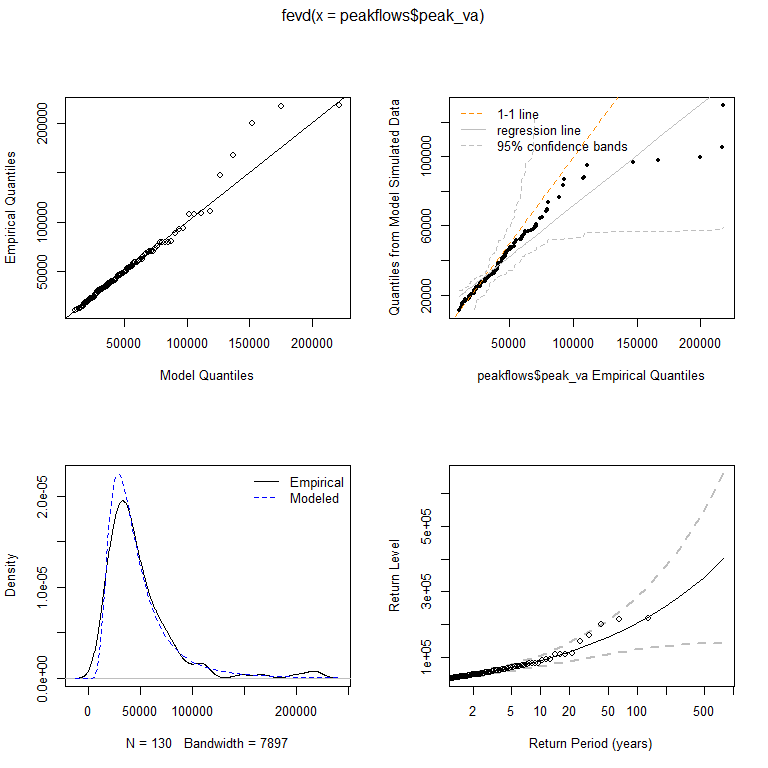

In [ ]:
GEVD <- fevd(peakflows$peak_va)

summary(GEVD)

We can now calculate flow magnitudes for the non-exceedance
probabilities in our peakflows data using the function qevd(). Use a
mutate to add a column of flows calculated from qevd, using the
parameters from your distribution fit (location, scale, shape) and the
non-exceedance probabilities calculated earlier (the pne column in the
peakflows data).

In [ ]:
peakflows <- peakflows |>
  mutate(
    GEVDflows = qevd(
     p = pne, 
     loc = location, 
     scale = scale, 
     shape = shape))

Now add a line showing flows you just calculated to the plot we made
above showing the Gumbel fit. Does this approach work better in this
case?

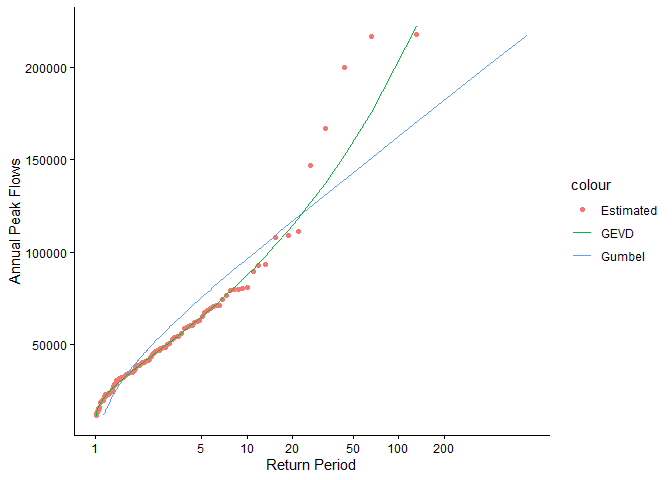

In [ ]:
#add a line to the plot above that shows the Gumbel fit
peakplot + 
  geom_line(data = peakflows, aes(x = Tp, y = GEVDflows, color = "GEVD"))

Finally, we can calculate the magnitude of a flow with a specific return
interval using the same qevd() function. If we want the 1 in 100 chance
flood. Our return interval would be 100 and the non-exceedance
probability would be 0.99 (pne above). Pass qevd this probability value
and the location, scale, and shape parameters you got above to get the 1
in 100 chance flood magnitude.

How is this different from what we calculated above? Do you think it is
more accurate? Why?

In [ ]:
#p from above is the 
qevd(p = .99, 
     loc = location, 
     scale = scale, 
     shape = shape)

location 
202781.6 

This is a good opportunity to illustrate the usefulness of writing your
own functions. When you install packages in R, you get a bunch of
functions you can use. But you can also create these on your own to
simplify your analyses!

You do this with the following syntax \>MyNewFunction \<-
function(param1, param2){ \>code \>}

Whatever the last line of the “code” portion of the function spits out,
get’s returned from the function. So if you said X \<-
mynewfunction(param1, parm2) X would now have it in whatever your
function returned. See a simple example below: a function that adds 1 to
any number we pass to it.

In [ ]:
add1 <- function(number){
          number + 1
          }

add1(4)

[1] 5

Let’s create a function that returns the return period for a flood of
any magnitude for the gage we are investigating. Creating functions is a
great way to streamline your workflow. You can write a function that
performs an operation you need to perform a bunch of times, then just
use the function rather than re-writing/copying the code.

Our function will be called “ReturnPeriod” and we will pass it the flow
we want the return period for, and the u and alpha of the distribution.

We will test the function by having it calculate the return period for
the 100 year flood we calculated earlier (120027). If it works, it
should spit out 100.

In [ ]:
ReturnPeriod <- function(flow, u, alpha){
  
  pTheoretical = exp(-exp(-((flow - u) / alpha)))
  TpTheoretical = (1 / (1 - pTheoretical))
  
  TpTheoretical
}

ReturnPeriod(158349, u, alpha)

[1] 85.65574

## Challenge: Create a function

Create a function that returns the 100 year flood when given a USGS gage
id. Use the generalized extreme value distribution fit function to do
this.